#**The Sparks Foundation** 
###**October 2022 batch** 
###**Computer Vision and IoT Internship**
###**Task4: Implement Real Time mask detection (Level - Intermediate)**
###**Intern Name: Emad Addeen Adeeb**


In this task I will be implementing face mask detection using YOLOv4

In order to do that we need to coolect training dataset, I did downlaod dataset from kaggle that contains three classes (**with_mask**, **without_mask**, **mask_weared_incorrect**) with 853 different images.

I did train my model using YOLOv4 weights, however the mAP was pretty low and did poorly in real time detection.



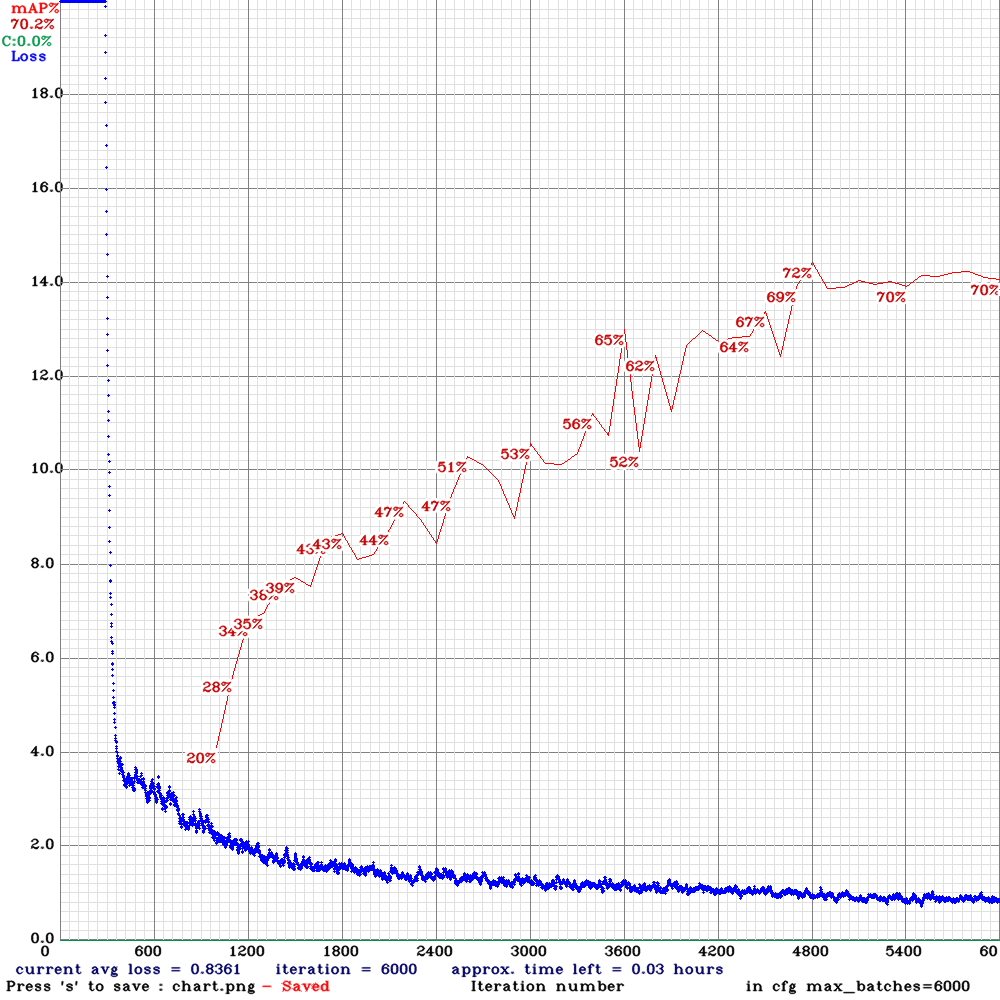

therefore I will be using a pretrained model with higher accuracy downloaded from https://github.com/mrtucar/FaceMaskDetection.git


But in order to know exactly what we'ver been through, let's give you a look around.

Some datasets espicially when dealing with YOLO (because you have to provide the bounding box coordinates of the desired objects) provide the annotation in PASCAL VOC format. this notebook makes sure to change the format of those files to the desired(YOLO desired) format.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip "/content/drive/MyDrive/tiny_yolo/archive.zip" -d "/content/drive/MyDrive/tiny_yolo/"A

Archive:  /content/drive/MyDrive/tiny_yolo/archive.zip
replace /content/drive/MyDrive/tiny_yolo/annotations/maksssksksss0.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/drive/MyDrive/tiny_yolo/annotations/maksssksksss0.xml  
  inflating: /content/drive/MyDrive/tiny_yolo/annotations/maksssksksss1.xml  
  inflating: /content/drive/MyDrive/tiny_yolo/annotations/maksssksksss10.xml  
  inflating: /content/drive/MyDrive/tiny_yolo/annotations/maksssksksss100.xml  
  inflating: /content/drive/MyDrive/tiny_yolo/annotations/maksssksksss101.xml  
  inflating: /content/drive/MyDrive/tiny_yolo/annotations/maksssksksss102.xml  
  inflating: /content/drive/MyDrive/tiny_yolo/annotations/maksssksksss103.xml  
  inflating: /content/drive/MyDrive/tiny_yolo/annotations/maksssksksss104.xml  
  inflating: /content/drive/MyDrive/tiny_yolo/annotations/maksssksksss105.xml  
  inflating: /content/drive/MyDrive/tiny_yolo/annotations/maksssksksss106.xml  
  inflating: /content/drive/MyDrive/ti

In [20]:
from IPython.display import Image  # for displaying images
import os
import random
import shutil
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt


# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()

    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text

        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))

            info_dict['image_size'] = tuple(image_size)

        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text

                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)
            info_dict['bboxes'].append(bbox)

    return info_dict

#info_dict = extract_info_from_xml("C:/Users/Adeeb/Desktop/Genetic Algorithms/archive/annotations/maksssksksss0.xml")

# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"with_mask": 0,
                            "without_mask": 1,
                            "mask_weared_incorrect": 2}


# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolo(info_dict):
    print_buffer = []

    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())

        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width = (b["xmax"] - b["xmin"])
        b_height = (b["ymax"] - b["ymin"])

        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]
        b_center_x /= image_w
        b_center_y /= image_h
        b_width /= image_w
        b_height /= image_h

        # Write the bbox details to the file
        print_buffer.append(
            "{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))

    # Name of the file which we have to save
    save_file_name = os.path.join("/content/drive/MyDrive/tiny_yolo/annotations/", info_dict["filename"].replace("png", "txt"))

    # Save the annotation to disk
    print("\n".join(print_buffer), file=open(save_file_name, "w"))

# Get the annotations
annotations = [os.path.join('/content/drive/MyDrive/tiny_yolo/annotations/', x) for x in os.listdir('/content/drive/MyDrive/tiny_yolo/annotations/') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolo(info_dict)
annotations = [os.path.join('/content/drive/MyDrive/tiny_yolo/annotations/', x) for x in os.listdir('/content/drive/MyDrive/tiny_yolo/annotations/') if x[-3:] == "txt"]

100%|██████████| 853/853 [00:07<00:00, 116.92it/s]


**Now** let's get some visuals of those annotations.

In [21]:
random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

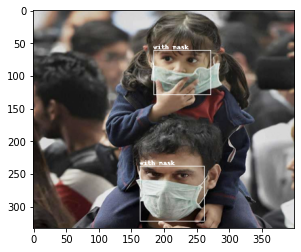

In [23]:
# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)